# ML on ESDC using PyTorch 
A DeepESDL example notebook

## Linear Regression for prediction of missing land surface temperature values from air temperature values
This notebook showcases how to implement Masked Machine Learning on the Earth System Data Cube using PyTorch. In some areas no values are intended (land surface temperature in the ocean). If the data samples are multidimensional (e.g. 2D matrices) no predictions on the oceans can be made. In the following example those values are replaced with a constant and not included within the loss computation.

Please, also refer to the DeepESDL documentation and visit the platform's website for further information!

ScaDS.AI, 2023

**This notebook runs needs a python conda environment with pytorch and mlflow installed, please checkout the documentation for help on [changing the environment](https://deepesdl.readthedocs.io/en/v2022.12.1/guide/jupyterlab/). You can follow the MLFlow Experiment run via the bundled MLFlow UI.**

### Import necessary libraries

In [1]:
import os
import torch
import numpy as np
import xarray as xr
import dask.array as da
import torch.nn.functional as F
from global_land_mask import globe
from torch.utils.data import TensorDataset
from xcube.core.store import new_data_store

### Load Data (Earth System Data Cube)
We load the ESDC (*.zarr) from the s3 data store (lazy load). The ESDC consists of three dimensions (longitude, latitude, time). Out of many available cube variables, which are dask arrays, we load two ("land_surface_temperature", "air_temperature_2m"). 

In [2]:
data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset    = data_store.open_data("esdc-8d-0.083deg-184x270x270-2.1.1.zarr")
ds         = dataset[["land_surface_temperature", "air_temperature_2m"]]
ds

<xarray.Dataset>
Dimensions:                   (time: 1840, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 1979-01-05 ... 2018-12-31
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Add land mask variable 
Here we exclude redundant water surface values for our use case and only consider solid Earth data for our ML analysis. We extend the ESDC by a new variable "land_mask". The mask is a data array initialized for one time slice of the ESDC. 

In [3]:
lon_grid, lat_grid = np.meshgrid(ds.lon,ds.lat)
lm0                = da.from_array(globe.is_land(lat_grid, lon_grid))
lm0

dask.array<array, shape=(2160, 4320), dtype=bool, chunksize=(2160, 4320), chunktype=numpy.ndarray>

We now extend the mask to all time slices of the ESDC.

In [4]:
lm = da.stack([lm0 for i in range(ds.sizes["time"])], axis = 0)
lm

dask.array<stack, shape=(1840, 2160, 4320), dtype=bool, chunksize=(1, 2160, 4320), chunktype=numpy.ndarray>

We add the mask as variable to the ESDC. The cube now consists of three equally chunked variables ("land_surface_temperature", "air_temperature_2m", "land_mask"). 

In [5]:
from ml4xcube.cube_utilities import get_chunk_sizes

ds = ds.assign(
    land_mask = (
        ["time","lat","lon"],
        lm.rechunk(
            chunks=([v for k,v in get_chunk_sizes(ds)])
        )
    )
)
ds

<xarray.Dataset>
Dimensions:                   (time: 1840, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 1979-01-05 ... 2018-12-31
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Select cuda device if available to use GPU ressources

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### Train-/ and Test Set Creation and Preprocessing

Initialize XrDataset to analyze 10x10 data samples considering spatial relations.
If drop_nan_masked is True, ensures that samples are not dropped entirely if they contain NaN values in oceanic regions(determined by the 'land_mask' variable). This enables the of coastal regions.

In [7]:
from ml4xcube.datasets.xr_dataset import XrDataset

dataset = XrDataset(
    ds              = ds,
    chunk_indices   = [841],
    sample_size     = [("time", 1), ("lat", 10), ("lon", 10)],
    filter_var      = "land_mask",
    drop_nan_masked = True 
).get_dataset()


{'land_surface_temperature': array([[[299.22238, 299.0216 , 299.9444 , ..., 306.386  , 308.4484 ,
         305.03638],
        [299.22913, 299.01898, 295.65298, ..., 302.61038, 306.8856 ,
         305.1488 ],
        [298.7257 , 296.06677, 295.8856 , ..., 295.9374 , 301.2908 ,
         304.0402 ],
        ...,
        [300.5362 , 304.07   , 302.5116 , ..., 302.9394 , 301.201  ,
         302.2964 ],
        [301.4888 , 306.0364 , 309.2974 , ..., 302.5    , 301.2826 ,
         301.62878],
        [301.0852 , 308.3744 , 310.55978, ..., 301.65378, 300.6062 ,
         299.7104 ]],

       [[308.9914 , 309.3324 , 302.8112 , ..., 303.07797, 302.9032 ,
         303.0516 ],
        [306.3154 , 306.1868 , 304.1796 , ..., 303.18118, 303.2844 ,
         303.20798],
        [303.81277, 303.0034 , 302.788  , ..., 303.28918, 303.5144 ,
         303.1532 ],
        ...,
        [302.7976 , 302.5908 , 301.49298, ..., 304.3764 , 304.6392 ,
         304.37558],
        [302.67117, 302.3416 , 301.742  , .

Calculate range (min, max) of data variables for normalization and adjust the minimum value.
This ensures that no actual zeros are contained in normalized data for later masking of NaNs.

In [8]:
from ml4xcube.preprocessing import get_range, normalize

# Get ramge for normalization
lst_range = get_range(dataset, "land_surface_temperature")
at_range  = get_range(dataset, "air_temperature_2m")

# Subtract small number from min value to prevent zeros in normalized data
lst_range[0] -= 1e-9
at_range[0]  -= 1e-9

#normalize dataset
dataset["air_temperature_2m"]       = normalize(dataset["air_temperature_2m"], *at_range)
dataset["land_surface_temperature"] = normalize(dataset["land_surface_temperature"], *lst_range)

dataset

{'land_surface_temperature': array([[[0.57901305, 0.57652223, 0.58797026, ..., 0.667884  ,
          0.69347   , 0.65114087],
         [0.5790967 , 0.5764897 , 0.53473145, ..., 0.6210442 ,
          0.67408204, 0.6525356 ],
         [0.57285136, 0.53986484, 0.53761715, ..., 0.53826   ,
          0.6046736 , 0.63878226],
         ...,
         [0.59531206, 0.63915217, 0.6198187 , ..., 0.6251259 ,
          0.60355943, 0.6171488 ],
         [0.60713   , 0.66354716, 0.7040026 , ..., 0.6196748 ,
          0.6045718 , 0.60886663],
         [0.602123  , 0.6925519 , 0.7196637 , ..., 0.6091767 ,
          0.59618056, 0.5850672 ]],
 
        [[0.7002064 , 0.70443684, 0.6235354 , ..., 0.6268451 ,
          0.6246769 , 0.626518  ],
         [0.6670083 , 0.6654129 , 0.64051175, ..., 0.6281255 ,
          0.6294059 , 0.6284579 ],
         [0.635961  , 0.6259198 , 0.6232477 , ..., 0.6294654 ,
          0.6322594 , 0.62777835],
         ...,
         [0.6233669 , 0.62080115, 0.60718185, ..., 0.642953

Mask NaN values with 0 across the dataset, since a neural network does not handle NaNs.

In [9]:
from ml4xcube.preprocessing import fill_masked_data

dataset = fill_masked_data(
    ds     = dataset, 
    vars   = ["air_temperature_2m", "land_surface_temperature"], # Variables to fill
    method = "constant",                                         # Fill the data with a constant value
    const  = 0                                                   # Set the constand value to 0
)

dataset

{'land_surface_temperature': array([[[0.57901305, 0.57652223, 0.58797026, ..., 0.667884  ,
          0.69347   , 0.65114087],
         [0.5790967 , 0.5764897 , 0.53473145, ..., 0.6210442 ,
          0.67408204, 0.6525356 ],
         [0.57285136, 0.53986484, 0.53761715, ..., 0.53826   ,
          0.6046736 , 0.63878226],
         ...,
         [0.59531206, 0.63915217, 0.6198187 , ..., 0.6251259 ,
          0.60355943, 0.6171488 ],
         [0.60713   , 0.66354716, 0.7040026 , ..., 0.6196748 ,
          0.6045718 , 0.60886663],
         [0.602123  , 0.6925519 , 0.7196637 , ..., 0.6091767 ,
          0.59618056, 0.5850672 ]],
 
        [[0.7002064 , 0.70443684, 0.6235354 , ..., 0.6268451 ,
          0.6246769 , 0.626518  ],
         [0.6670083 , 0.6654129 , 0.64051175, ..., 0.6281255 ,
          0.6294059 , 0.6284579 ],
         [0.635961  , 0.6259198 , 0.6232477 , ..., 0.6294654 ,
          0.6322594 , 0.62777835],
         ...,
         [0.6233669 , 0.62080115, 0.60718185, ..., 0.642953

#### Train/Test assignment
Before the train/test split can be assigned, the dataset available as dict must be transformed to an xarray dataset

In [10]:
from ml4xcube.cube_utilities import assign_dims
from ml4xcube.data_split import assign_block_split

# transform dataset to xarray
dataset = {var: da.from_array(dataset[var]) for var in dataset.keys()}
dataset = assign_dims(dataset, ("batch", "lat", "lon"))
dataset = xr.Dataset(dataset)

# assign train/test split
dataset = assign_block_split(dataset, block_size=[("batch", 1), ("lat", 10), ("lon", 10)], split=0.8)
dataset

<xarray.Dataset>
Dimensions:                   (batch: 45527, lat: 10, lon: 10, time: 45527)
Dimensions without coordinates: batch, lat, lon, time
Data variables:
    land_surface_temperature  (batch, lat, lon) float32 dask.array<chunksize=(45527, 10, 10), meta=np.ndarray>
    air_temperature_2m        (batch, lat, lon) float32 dask.array<chunksize=(45527, 10, 10), meta=np.ndarray>
    land_mask                 (batch, lat, lon) bool dask.array<chunksize=(45527, 10, 10), meta=np.ndarray>
    split                     (time, lat, lon) float64 dask.array<chunksize=(1, 10, 10), meta=np.ndarray>

Before the training step the data data is reshaped from a matrix of 10x10 to an array with 100 elements

In [11]:
# Convert the data back to numpy
ds = {var: dataset[var].values for var in dataset.data_vars}

# Flatten all samples
ds["air_temperature_2m"]       = ds["air_temperature_2m"].reshape(ds["air_temperature_2m"].shape[0], -1)
ds["land_surface_temperature"] = ds["land_surface_temperature"].reshape(ds["land_surface_temperature"].shape[0], -1)
ds["split"]                    = ds["split"].reshape(ds["split"].shape[0], -1)

# Assign independent variable X and dependent variable y before training
X = ds["air_temperature_2m"]
y = ds["land_surface_temperature"]

X.shape, y.shape

((45527, 100), (45527, 100))

Split the data into train and test set

In [12]:
# Create mask emphasize train and test data in ds
train_mask = np.all(ds["split"] == 1, axis=1)
test_mask  = np.all(ds["split"] == 0, axis=1)

# Apply boolean indexing
X_train = X[train_mask]
X_test  = X[test_mask]
y_train = y[train_mask]
y_test  = y[test_mask]

#### Prepare Datasets before Training

In [13]:
from ml4xcube.datasets.pytorch import prepare_dataloader

train_ds     = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = prepare_dataloader(train_ds, batch_size=64, num_workers=5, parallel=False)
test_ds      = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
test_loader  = prepare_dataloader(test_ds, batch_size=64, num_workers=5, parallel=False)

### Define masked Loss Function
Oceanic Regions (NaNs) are masked with 0 to enable the training of a neural net. 
Therefore these are not considered during the loss computation

In [14]:
def masked_mse(y_true, y_pred, mask_value=0):
    # Create a mask for all elements not equal to the mask_value (e.g., zero)
    mask = (y_true != mask_value)

    # Apply the mask to both y_true and y_pred
    masked_true = y_true[mask]
    masked_pred = y_pred[mask]

    # Compute the Mean Squared Error
    mse = F.mse_loss(masked_pred, masked_true)

    return mse

### Define model and optimizer

In [15]:
reg_model = torch.nn.Sequential(
    torch.nn.Linear(in_features=100, out_features=64),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.01),
    torch.nn.Linear(in_features=64, out_features=32),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.01),
    torch.nn.Linear(in_features=32, out_features=32),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.01),
    torch.nn.Linear(in_features=32, out_features=32),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.01),
    torch.nn.Linear(in_features=32, out_features=64),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.01),
    torch.nn.Linear(in_features=64, out_features=100)  # No activation on the final layer for regression
)

optimizer = torch.optim.SGD(reg_model.parameters(), lr=0.03)

### Train model

Epoch 1: Average Loss: 4.2931e-01
Epoch 1: Validation Loss: 4.2997e-01
New best model saved with validation loss: 0.4299704692997299
Epoch 2: Average Loss: 4.2931e-01
Epoch 2: Validation Loss: 4.3000e-01
Epoch 3: Average Loss: 4.2931e-01
Epoch 3: Validation Loss: 4.2981e-01
New best model saved with validation loss: 0.42980727595049184
Epoch 4: Average Loss: 4.2931e-01
Epoch 4: Validation Loss: 4.2989e-01
Epoch 5: Average Loss: 4.2930e-01
Epoch 5: Validation Loss: 4.2987e-01
Epoch 6: Average Loss: 4.2931e-01
Epoch 6: Validation Loss: 4.2991e-01
Epoch 7: Average Loss: 4.2930e-01
Epoch 7: Validation Loss: 4.2989e-01
Epoch 8: Average Loss: 4.2930e-01
Epoch 8: Validation Loss: 4.2988e-01
Stopping early due to no improvement.
Loaded best model weights.


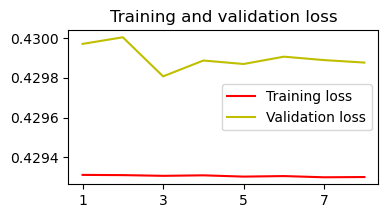

In [16]:
from ml4xcube.training.pytorch import Trainer

# Trainer instance
trainer = Trainer(
    model            = reg_model,
    train_data       = train_loader,
    test_data        = test_loader,
    optimizer        = optimizer,
    best_model_path  = "./best_model.pth",
    early_stopping   = True,
    loss             = masked_mse,
    patience         = 5,
    epochs           = 20,
    create_loss_plot = True
)

# Start training
reg_model = trainer.train()